# Process data

## Process error-based metrics (MAE, RMSE, NSE) with window lengths 90
(together with model size and runtime)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

CUR_ABS_DIR = Path.cwd().resolve()
PROJ_DIR = (CUR_ABS_DIR / '../../../').resolve()
OUTPUT_DIR = (PROJ_DIR / 'swissrivernetwork/benchmark/outputs/ray_results/').resolve()
DUMP_DIR = (CUR_ABS_DIR / 'outputs/radar/').resolve()

LOAD_LATEST_RESULTS = True

ISSUE_TAG = '<span style="color:red;">[issue]</span> '
INFO_TAG = '<span style="color:blue;">[info]</span> '
SUCCESS_TAG = '<span style="color:green;">[success]</span> '


def print(text=None):
    from IPython.display import display, HTML
    if text is None:
        display(HTML("<br>"))
        return
    text = str(text)
    display(HTML(text))


print(f'{INFO_TAG} Project directory: {PROJ_DIR}')
print(f'{INFO_TAG} Current directory: {CUR_ABS_DIR}')
print(f'{INFO_TAG} Output directory: {OUTPUT_DIR}')
print(f'{INFO_TAG} Dump directory: {DUMP_DIR}')

In [3]:
# Get Err 90 data, Model Size data, Runtime data

import pandas as pd
import os
import json


def read_results_from_csv(
        output_dir: Path, graph_name: str, method: str, filename_key: str = 'results', verbose: bool = False
) -> pd.DataFrame:
    file_path = os.path.join(output_dir, f'{graph_name}_{method}_{filename_key}.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        if verbose:
            print(f"{SUCCESS_TAG} Loaded results from {file_path}.")
        return df
    else:
        if verbose:
            print(f"{INFO_TAG} No results found at {file_path}.")
        return pd.DataFrame()


def save_results_to_csv(
        df: pd.DataFrame, output_dir: Path, graph_name: str, method: str, filename_key: str = 'results',
        verbose: bool = True
) -> str:
    output_dir.mkdir(parents=True, exist_ok=True)
    file_path = os.path.join(output_dir, f'{graph_name}_{method}_{filename_key}.csv')
    df.to_csv(file_path, index=False)
    if verbose:
        print(f"{SUCCESS_TAG} Saved results to {file_path}.")
    return file_path


def read_results_from_json(
        output_dir: Path, graph_name: str, method: str, filename_key: str = 'results', verbose: bool = False
) -> dict:
    file_path = os.path.join(output_dir, f'{graph_name}_{method}_{filename_key}.json')
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            data = json.load(f)
        if verbose:
            print(f"{SUCCESS_TAG} Loaded extra results from {file_path}.")
        return data
    else:
        if verbose:
            print(f"{INFO_TAG} No extra results found at {file_path}.")
        return {}


def save_results_to_json(
        data: dict, output_dir: Path, graph_name: str, method: str, filename_key: str = 'results',
        verbose: bool = True
) -> str:
    output_dir.mkdir(parents=True, exist_ok=True)
    file_path = os.path.join(output_dir, f'{graph_name}_{method}_{filename_key}.json')
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)
    if verbose:
        print(f"{SUCCESS_TAG} Saved results to {file_path}.")
    return file_path

In [4]:
from swissrivernetwork.benchmark.ray_evaluation import process_method
from swissrivernetwork.benchmark.util import get_run_extra_key, is_transformer_model
from typing import Union


def infer_single_run(graph_name: str, method: str, df_res: pd.DataFrame, settings: dict) -> (pd.DataFrame, dict):
    import numpy as np

    max_days = 500 if method == 'transformer_embedding' else np.inf
    # window_len = 90  # curate_window_lens(WINDOW_LENS, graph_name, mode='subsequences', max_days=max_days)
    # print(f'{INFO_TAG} Curated window lengths for graph="{graph_name}", method="{m}": {window_lens}')

    settings['path_extra_keys'] = get_run_extra_key(settings)

    df_data, extra_resu = process_method(
        graph_name, method, output_dir=OUTPUT_DIR, settings=settings, return_extra=True
    )
    new_row = {'window_len': settings['window_len']}
    for metric in ['RMSE', 'MAE', 'NSE']:
        for stat_measure in ['Mean', 'Std', 'Median', 'Min', 'Max']:
            col_name = f'{metric}_{stat_measure}'
            if metric in df_data.columns:
                value = df_data[df_data['Station'] == stat_measure][metric]
                if not value.empty:
                    new_row[col_name] = value.values[0]
                else:
                    new_row[col_name] = np.nan
            else:
                new_row[col_name] = np.nan
    # Add extra results:
    extra_resu_keys = [k for k in df_data.keys().to_list() if k.startswith('extra__')]
    for extra_key in extra_resu_keys:
        new_row[f'{extra_key}_Mean'] = df_data[df_data['Station'] == 'Mean'][extra_key].values[0]
    for key in extra_resu.keys():
        if f'extra__{key}' not in new_row:
            new_row[f'extra__{key}'] = extra_resu[key]

    df_res = pd.concat([df_res, pd.DataFrame([new_row])], ignore_index=True)
    return df_res, extra_resu


def infer_lstm(
        graph_name: str, method: str, df_res: pd.DataFrame, settings: dict
) -> Union[pd.DataFrame, str] | None:
    window_len = settings['window_len']
    if not df_res.empty and window_len in df_res['window_len'].values:
        print(f"{SUCCESS_TAG} Results for window_len={window_len} already exist. Skipping...")
        return None, None

    settings.update(
        {
            'positional_encoding': 'none',
        }
    )

    df_res, extra_resu = infer_single_run(graph_name, method, df_res, settings)
    file_path = save_results_to_csv(df_res, DUMP_DIR, graph_name, method, filename_key='err_90', verbose=True)
    # file_path_extra = save_results_to_json(
    #     extra_resu, DUMP_DIR, graph_name, method, filename_key='extra_resu', verbose=True
    # )
    return df_res, file_path


def infer_transformer(
        graph_name: str, method: str, df_res: pd.DataFrame, settings: dict
) -> Union[pd.DataFrame, str] | None:
    window_len = settings['window_len']
    position_encodings = ['learnable', 'sinusoidal', 'rope']  # [None, 'learnable', 'sinusoidal', 'rope']
    updated = False
    for pe in position_encodings:
        print(f'{INFO_TAG} --- Processing positional_encoding={pe} ---')
        if not df_res.empty and window_len in df_res['window_len'].values and pe in df_res[
            'positional_encoding'].values:
            print(
                f'{SUCCESS_TAG} Results for window_len={window_len}, positional_encoding={pe} already exist. Skipping...'
            )
            continue

        settings.update(
            {
                'max_len': 500,
                'positional_encoding': pe,  # 'learnable' or 'sinusoidal' or 'rope' or None
            }
        )

        df_res, extra_resu = infer_single_run(graph_name, method, df_res, settings)  # Already concatenated
        if 'positional_encoding' in df_res.columns:
            df_res.loc[df_res.index[-1], 'positional_encoding'] = pe
        else:
            df_res.insert(loc=1, column='positional_encoding', value=pe)

        file_path = save_results_to_csv(df_res, DUMP_DIR, graph_name, method, filename_key='err_90', verbose=True)

        updated = True

    if not updated:
        return None, None

    return df_res, file_path


def infer_graph(graph_name: str, methods: list[str], window_len: int = 90):
    for m in methods:
        print()
        print(f'{INFO_TAG} #### Starting processing for method="{m}" on graph="{graph_name}"...')

        df_res = read_results_from_csv(DUMP_DIR, graph_name, m, filename_key='err_90')
        # extra_resu = read_results_from_json(DUMP_DIR, graph_name, m, filename_key='extra_resu')
        # print(f"{INFO_TAG} ==== Processing window_len={window_len} [{i_len + 1}/{len(window_lens)}] ====")

        settings = {
            'missing_value_method': None,  # 'mask_embedding' or 'interpolation' or 'zero' or None
            'use_current_x': True,
            'window_len': 90,
            'verbose': 1,
            'env': 'notebook',
        }

        if is_transformer_model(m):
            df_res, file_path = infer_transformer(graph_name, m, df_res, settings)
        else:
            df_res, file_path = infer_lstm(graph_name, m, df_res, settings)
        if df_res is None:
            continue

        print(f'{SUCCESS_TAG} Completed processing for window_len={window_len}. Results saved to {file_path}. ')

        print(f'{SUCCESS_TAG} #### Finished processing for method="{m}" on graph="{graph_name}"!')

In [5]:
GRAPH_NAMES = ['swiss-1990', 'swiss-2010', 'zurich']
METHODS = ['lstm', 'transformer', 'graphlet', 'transformer_graphlet', 'lstm_embedding', 'transformer_embedding',
           'stgnn', 'transformer_stgnn']

In [6]:
# Compute results and save to CSV:
for graph_name in GRAPH_NAMES[0:]:
    print(f'{INFO_TAG} ================= Starting processing for graph="{graph_name}" =================')
    infer_graph(graph_name, METHODS[0:4], window_len=90)  # test [2:3]

# Plot radar charts

## Gather data

### Gather Err 90 data, Model Size data, Runtime data

In [7]:
GRAPH_NAMES = ['swiss-1990', 'swiss-2010', 'zurich']
METHODS = ['lstm', 'transformer', 'graphlet', 'transformer_graphlet', 'lstm_embedding', 'transformer_embedding',
           'stgnn', 'transformer_stgnn']

In [8]:
import pandas as pd


def get_err_from_df_lstm(df_res: pd.DataFrame, metric: str, window_len: int = 90) -> float | None:
    # Filter rows with window_len=window_len
    df_filtered = df_res[df_res['window_len'] == window_len]
    if df_filtered.empty:
        print(f'{ISSUE_TAG} No data found for window_len={window_len}.')
        return None
    if len(df_filtered) > 1:
        raise ValueError(f'{ISSUE_TAG} Multiple rows found for window_len={window_len}. Expected only one.')
    return float(df_filtered.iloc[0][metric])


def get_err_from_df_transformer(df_res: pd.DataFrame, metric: str, window_len: int = 90) -> float | None:
    # Filter rows with window_len=window_len
    df_filtered = df_res[df_res['window_len'] == window_len]
    if df_filtered.empty:
        print(f'{ISSUE_TAG} No data found for window_len={window_len}.')
        return None
    # Get the row with the best metric (lowest for RMSE and MAE, highest for NSE):
    if metric.startswith('RMSE') or metric.startswith('MAE'):
        best_row = df_filtered.loc[df_filtered[metric].idxmin()]
    elif metric.startswith('NSE'):
        best_row = df_filtered.loc[df_filtered[metric].idxmax()]
    elif any([k in metric for k in ['model_size', 'train_time', 'infer_time']]):
        best_row = df_filtered.loc[df_filtered['RMSE_Mean'].idxmin()]  # Choose the one with min RMSE Mean
    else:
        print(f'{ISSUE_TAG} Unknown metric "{metric}".')
        return None
    return float(best_row[metric])


def gather_err_data(
        graph_names: list[str], methods: list[str], metric: str = 'RMSE_Mean', window_len: int = 90
) -> dict:
    data = {}
    for graph_name in graph_names:
        data[graph_name] = {}
        for method in methods:
            df_res = read_results_from_csv(DUMP_DIR, graph_name, method, filename_key='err_90')
            if df_res.empty:
                print(f"{ISSUE_TAG} No data found for graph='{graph_name}', method='{method}'. Skipping...")
                continue
            if is_transformer_model(method):
                result = get_err_from_df_transformer(df_res, metric, window_len=window_len)
            else:
                result = get_err_from_df_lstm(df_res, metric, window_len=window_len)
            print(f'{SUCCESS_TAG} Gathered {metric}={result} for graph="{graph_name}", method="{method}".')

            data[graph_name][method] = result

    return data


def normalize_err_data(
        err_data: dict, min_is_better: bool = True, global_min: float | None = None, global_max: float | None = None,
) -> dict:
    """
    Normalize error data to [0, 1] range across all graphs and methods. Higher values are better.
    """
    # Find global min and max
    all_values = []
    for graph_name in err_data:
        for method in err_data[graph_name]:
            value = err_data[graph_name][method]
            if value is not None:
                all_values.append(value)
    global_min = min(all_values) if global_min is None else global_min
    global_max = max(all_values) if global_max is None else global_max

    # Normalize data
    normalized_data = {}
    for graph_name in err_data:
        normalized_data[graph_name] = {}
        for method in err_data[graph_name]:
            value = err_data[graph_name][method]
            if value is None:
                normalized_value = None
            else:
                if min_is_better:
                    normalized_value = (global_max - value) / (global_max - global_min)  # Higher is better
                else:
                    normalized_value = (value - global_min) / (global_max - global_min)  # Higher is better
            normalized_data[graph_name][method] = normalized_value

    return normalized_data

In [9]:
metric = 'RMSE_Mean'
err_90_data = gather_err_data(GRAPH_NAMES, METHODS, metric, window_len=90)
normalized_err_90_data = normalize_err_data(err_90_data, min_is_better=(not metric.startswith('NSE')))
print(normalized_err_90_data)

In [10]:
metric = 'MAE_Mean'
mae_data = gather_err_data(GRAPH_NAMES, METHODS, metric, window_len=90)
normalized_mae_data = normalize_err_data(mae_data, min_is_better=True)
print(normalized_mae_data)

In [11]:
metric = 'NSE_Mean'
nse_data = gather_err_data(GRAPH_NAMES, METHODS, metric, window_len=90)
normalized_nse_data = nse_data  # normalize_err_data(nse_data, min_is_better=False, global_min=0.0, global_max=1.0)
print(normalized_nse_data)

In [12]:
# Model size:
metric = 'extra__model_size'
model_size_data = gather_err_data(GRAPH_NAMES, METHODS, metric, window_len=90)
normalized_model_size_data = normalize_err_data(model_size_data, min_is_better=True)
print(normalized_model_size_data)

In [13]:
# Inference time per time step:
metric = 'extra__infer_time_per_time_step_Mean'
infer_time_data = gather_err_data(GRAPH_NAMES, METHODS, metric, window_len=90)
normalized_infer_time_data = normalize_err_data(infer_time_data, min_is_better=True)
print(normalized_infer_time_data)

In [14]:
# Train time total for the best model (hyperparameters)
metric = 'extra__train_time_total_best_Mean'
train_time_data = gather_err_data(GRAPH_NAMES, METHODS, metric, window_len=90)
normalized_train_time_data = normalize_err_data(train_time_data, min_is_better=True)
print(normalized_train_time_data)

### Combine all data into a single structure for plotting

In [15]:
data = [[]]
for graph_name in GRAPH_NAMES:
    data += [
        (f'{graph_name}, Isolated', [
            [],
            [],
        ]),
        (f'{graph_name}, Graphlet', [
            [],
            [],
        ]),
        (f'{graph_name}, Embedded', [
            [],
            [],
        ]),
        (f'{graph_name}, ST-GNN', [
            [],
            [],
        ]),
    ]


def append_data_to_visual(data: list, data_to_add: dict, varlabel_to_add: str) -> list:
    data[0].append(varlabel_to_add)
    n_models = 4
    for idx_g, graph_name in enumerate(GRAPH_NAMES):
        data[1 + n_models * idx_g][1][0].append(data_to_add[graph_name].get('lstm'))
        data[1 + n_models * idx_g][1][1].append(data_to_add[graph_name].get('transformer'))
        data[2 + n_models * idx_g][1][0].append(data_to_add[graph_name].get('graphlet'))
        data[2 + n_models * idx_g][1][1].append(data_to_add[graph_name].get('transformer_graphlet'))
        data[3 + n_models * idx_g][1][0].append(data_to_add[graph_name].get('lstm_embedding'))
        data[3 + n_models * idx_g][1][1].append(data_to_add[graph_name].get('transformer_embedding'))
        data[4 + n_models * idx_g][1][0].append(data_to_add[graph_name].get('stgnn'))
        data[4 + n_models * idx_g][1][1].append(data_to_add[graph_name].get('transformer_stgnn'))
    return data

In [16]:
data = append_data_to_visual(data, normalized_err_90_data, 'RMSE')
data = append_data_to_visual(data, normalized_mae_data, 'MAE')
data = append_data_to_visual(data, normalized_nse_data, 'NSE')
data = append_data_to_visual(data, normalized_model_size_data, 'MS')
data = append_data_to_visual(data, normalized_train_time_data, 'TT')
data = append_data_to_visual(data, normalized_infer_time_data, 'IT')
print(len(data))
print(data)

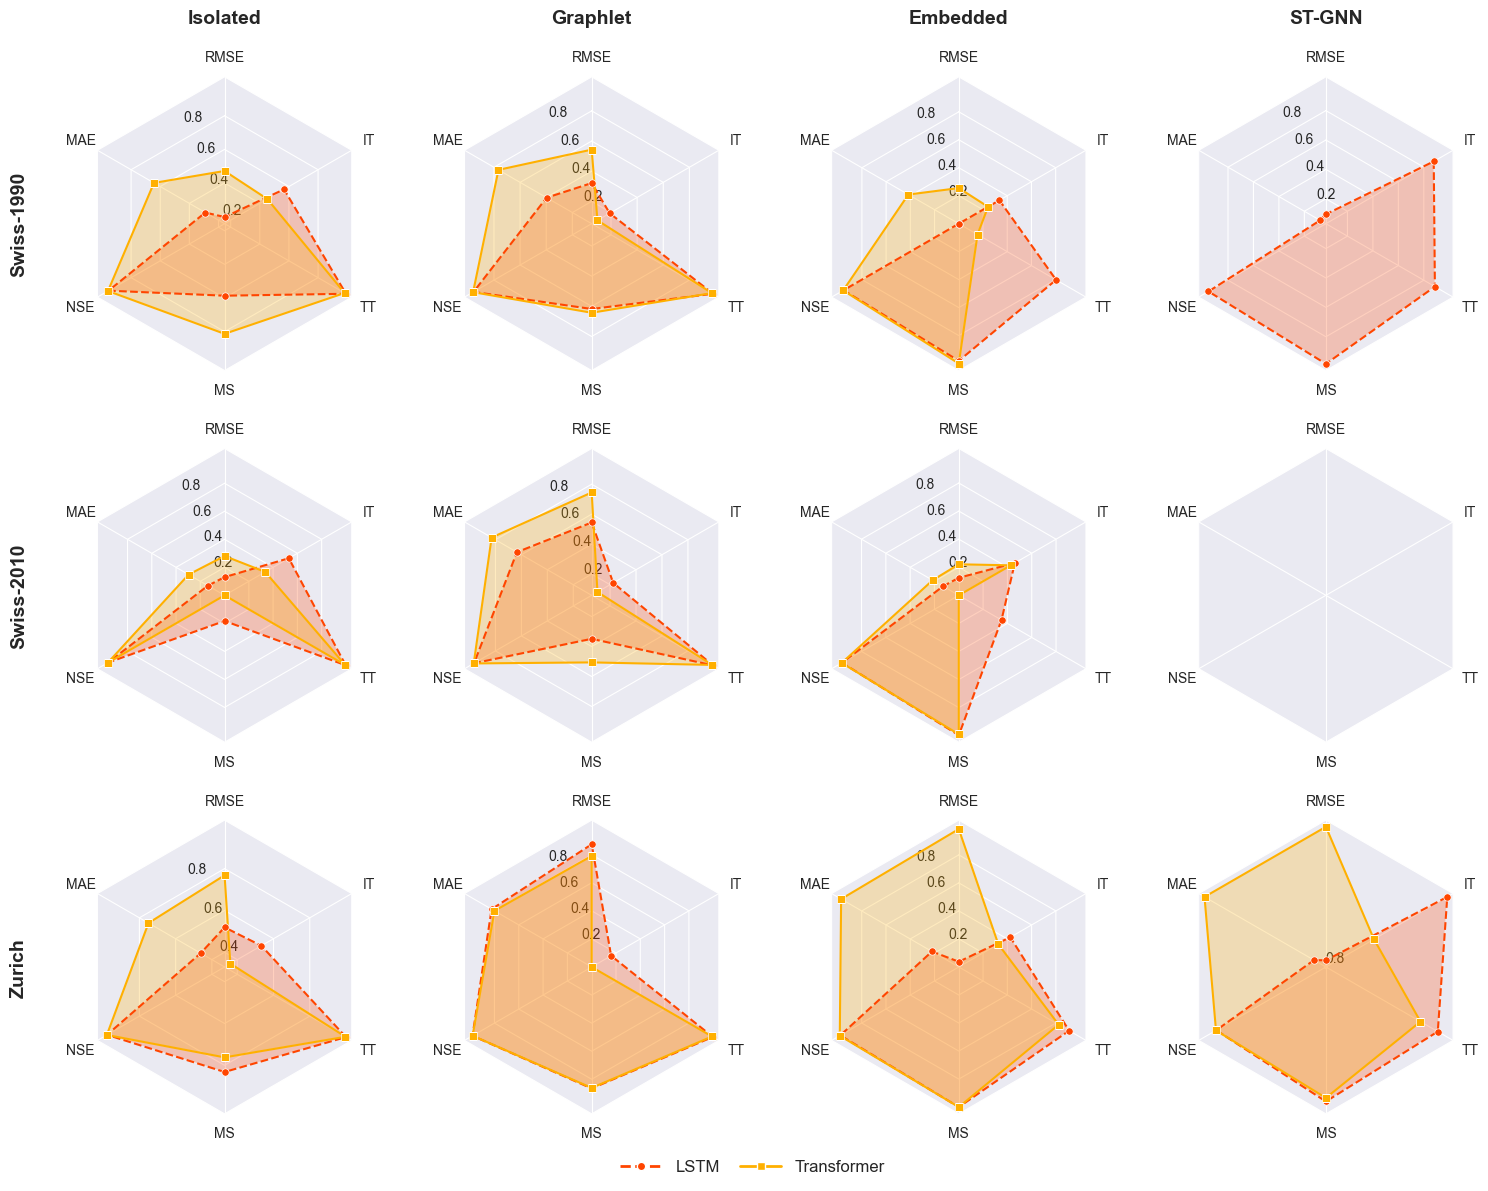

Button(button_style='success', description='Open in File Manager', style=ButtonStyle())

In [17]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

import seaborn as sns
from matplotlib.lines import Line2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)


    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)


    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform


        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')


        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)


        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)


        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)


        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)


        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon(
                    (0.5, 0.5), num_vars,
                    radius=.5, edgecolor="k"
                )
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(
                    axes=self,
                    spine_type='circle',
                    path=Path.unit_regular_polygon(num_vars)
                )
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(
                    Affine2D().scale(.5).translate(.5, .5)
                    + self.transAxes
                )
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)


    register_projection(RadarAxes)
    return theta


def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolyzed Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Err_90', 'MS', 'RT', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
        ('Basecase', [
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]]),
        ('With CO', [
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
            [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]]),
        ('With O3', [
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
            [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        ('CO & O3', [
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]]),
        ('CO & O3', [
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data


if __name__ == '__main__':
    # data = example_data()
    data = data

    N = len(data[1][1][0])  # number of variables
    theta = radar_factory(N, frame='polygon')

    spoke_labels = data.pop(0)
    print(spoke_labels)

    fig, axs = plt.subplots(
        figsize=(18, 13.5), nrows=3, ncols=4,
        subplot_kw=dict(projection='radar')
    )
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    sns.set_theme()  # style="whitegrid", font="Arial", font_scale=1.2)
    # colors = ['b', 'r', 'g', 'm', 'y']
    # colors = sns.color_palette("Spectral", n_colors=2)
    # cmap = plt.colormaps.get_cmap('Set1')  # 'Set1', 'autumn', 'YlOrRd_r', 'YlOrBr', 'Oranges', 'OrRd', 'OrRd_r'
    # colors = [cmap(i / 2) for i in range(2)]
    colors = ['#FF4500', '#FFB000']
    # colors = ['#F77F00', '#D62828']

    line_styles = ['--', '-']
    scatter_markers = ['o', 's']

    # Plot the four cases from the example data on separate Axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        # ax.set_title(
        #     title, weight='bold', size='medium', position=(0.5, 1.1),
        #     horizontalalignment='center', verticalalignment='center'
        # )
        for d, color, line_style, scatter_marker in zip(case_data, colors, line_styles, scatter_markers):
            ax.plot(theta, d, color=color, linestyle=line_style)
            ax.scatter(theta, d, color=color, marker=scatter_marker, s=28, zorder=10, edgecolors='w', linewidth=0.5)
            ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        ax.set_varlabels(spoke_labels)

    col_labels = ['Isolated', 'Graphlet', 'Embedded', 'ST-GNN']
    for col_idx, col_label in enumerate(col_labels):
        axs[0, col_idx].text(
            0.5, 1.2, col_label,
            transform=axs[0, col_idx].transAxes,
            ha='center', va='center',
            fontsize=14, weight='bold'
        )

    row_labels = ['Swiss-1990', 'Swiss-2010', 'Zurich']
    for row_idx, row_label in enumerate(row_labels):
        axs[row_idx, 0].text(
            -0.2, 0.5, row_label,
            transform=axs[row_idx, 0].transAxes,
            ha='center', va='center',
            rotation=90,
            fontsize=14, weight='bold'
        )

    # Add legend relative to bottom-center of figure:
    plt.subplots_adjust(bottom=0.07)
    labels = ('LSTM', 'Transformer')
    legend_elements = [
        Line2D(
            [0], [0], color=color, lw=2, linestyle=line_style,
            marker=scatter_marker, markersize=6, markerfacecolor=color,
            markeredgecolor='w', label=label
        )
        for color, line_style, scatter_marker, label in zip(colors, line_styles, scatter_markers, labels)
    ]
    legend = fig.legend(
        handles=legend_elements,
        # labels,
        loc='lower center',
        bbox_to_anchor=(0.5, 0.02),
        ncol=len(legend_elements),
        fontsize='medium',
        frameon=False,
        handlelength=2.5,
        columnspacing=1.2,
    )

    # fig.text(
    #     0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
    #     horizontalalignment='center', color='black', weight='bold',
    #     size='large'
    # )

    plt.show()

    # Save figure:
    output_path = CUR_ABS_DIR / 'figures' / 'all_resu_radar_grid_plot.pdf'
    output_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    from swissrivernetwork.util.os import make_open_button
    print(f'{SUCCESS_TAG}Saved grid plot to {output_path}.')
    make_open_button(output_path)

In [18]:
# Plotly example:
import plotly.express as px

df = px.data.wind()
fig = px.line_polar(
    df, r="frequency", theta="direction", color="strength", line_close=True,
    color_discrete_sequence=px.colors.sequential.Plasma_r, line_shape='linear',
    template="plotly", )

fig.update_layout(
    polar=dict(
        angularaxis=dict(griddash='solid'),
        radialaxis=dict(showline=True, linewidth=1, gridcolor='gray'),
        bgcolor='white'
    )
)

fig.show()